In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import random
from pathlib import Path
import time
import librosa
from sklearn.model_selection import train_test_split
import pickle
import cv2
from copy import deepcopy

In [ ]:
#melspectrogram

def get_melspectrogram(audio, sr=44100):
  mel_sgram = librosa.feature.melspectrogram(y=audio, sr=sr)
  mel_db_sgram = librosa.power_to_db(mel_sgram, ref=np.median)
  return mel_db_sgram

In [ ]:
#audio augmentation

def add_noise(audio, noise_limit):
  noise = np.random.randn(len(audio))   #np.random.randn: Gaussian distribution
  noise_audio = audio + noise * noise_limit
  return noise_audio

def shift_time(audio, shift_time_limit, remove_out_data, sr=44100):   #-0.5<=shift_time_limit<=0.5
  shift_time = (2*np.random.random()-1) * shift_time_limit   #np.random.random(): [0.0 , 1.0)
  shift_rate = int(shift_time * sr)
  shifted_audio = np.roll(audio, shift_rate)
  if remove_out_data == True:
    if shift_rate > 0:
      shifted_audio[:shift_rate] = 0
    else:
      shifted_audio[shift_rate:] = 0
  return shifted_audio

def change_pitch(audio, n_steps, sr=44100):
  return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def stretch_time(audio, rate):
  return librosa.effects.time_stretch(audio, rate=rate)

In [ ]:
#spectrogram augmentation

def time_masking(sgram, param):
  length = np.random.randint(param)
  start = np.random.randint(sgram.shape[1]-length)
  mask = np.zeros(sgram.shape)
  mask[:,start:start+length] = sgram[:,start:start+length] - sgram.min()
  mask_sgram = sgram - mask
  return mask_sgram

def freq_masking(sgram, param):
  length = np.random.randint(param)
  start = np.random.randint(sgram.shape[0]-length)
  mask = np.zeros(sgram.shape)
  mask[start:start+length,:] = sgram[start:start+length,:] - sgram.min()
  mask_sgram = sgram - mask
  return mask_sgram

In [ ]:
#set IRMAS-path

#IRMAS_path = "/Users/munchaeyong/Desktop/deep_learning/IRMAS-TrainingData"   #change to your directory
IRMAS_path = "/content/drive/MyDrive/IRMAS"

In [ ]:
#DON'T RUN IF NOT NECESSARY
#make IRMAS-TrainingData

Y = []
X_raw = []

DATADIR = Path(IRMAS_path)
for dir in list(DATADIR.iterdir()):
  if "txt" in str(dir):
    continue
  label = dir.name
  start = time.time()
  print(f"{label} start")
  for audio_file in list(dir.glob("*.wav")):
    audio, sr = librosa.load(str(audio_file), sr=None)
    X_raw.append(audio)
    Y.append(label)
  print(f"{label} finish: {time.time() - start}")

#label encoding
label_encoding_dic = {"cel":0, "cla":1, "flu":2, "gac":3, "gel":4, "org":5, "pia":6, "sax":7, "tru":8, "vio":9, "voi":10}
Y_label_enc = [label_encoding_dic[i] for i in Y]

print(len(X_raw))

In [ ]:
#DON'T RUN IF NOT NECESSARY
#make test set

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_raw, Y_label_enc, test_size = 0.2)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save train_val, test pickle data

file_name = IRMAS_path + "/X_train_val.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_train_val, fw)

file_name = IRMAS_path + "/X_test.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_test, fw)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save Y_label_encoded pickle data

file_name = IRMAS_path + "/Y_train_val.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(Y_train_val, fw)

file_name = IRMAS_path + "/Y_test.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(Y_test, fw)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#load train_val, test pickle data

with open(IRMAS_path + "/X_train_val.pickle","rb") as fr:
  X_train_val_load = pickle.load(fr)
with open(IRMAS_path + "/X_test.pickle","rb") as fr:
  X_test_load = pickle.load(fr)

In [ ]:
#load label pickle data

with open(IRMAS_path + "/Y_train_val.pickle","rb") as fr:
  Y_train_val_load = pickle.load(fr)
with open(IRMAS_path + "/Y_test.pickle","rb") as fr:
  Y_test_load = pickle.load(fr)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save train_val, test mel pickle data

X_train_val_mel = [get_melspectrogram(x) for x in X_train_val_load]

file_name = IRMAS_path + "/X_train_val_mel.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_train_val_mel, fw)

X_test_mel = [get_melspectrogram(x) for x in X_test_load]

file_name = IRMAS_path + "/X_test_mel.pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_test_mel, fw)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save shifted mel pickle data

shift_time_limit = -0.4   #-0.5<=shift_time_limit<=0.5
remove_out_data = False

X_shifted = [shift_time(x, shift_time_limit, remove_out_data) for x in X_train_val_load]
X_shifted_mel = [get_melspectrogram(x_shifted) for x_shifted in X_shifted]

file_name = IRMAS_path + "/aug/X_shifted_mel_" + str(shift_time_limit) + "_" + str(remove_out_data) + ".pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_shifted_mel, fw)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save pitch_changed mel pickle data

pitch_change = 5

X_pitch_changed = [change_pitch(x, pitch_change) for x in X_train_val_load]
X_pitch_changed_mel = [get_melspectrogram(x_pitch_changed) for x_pitch_changed in X_pitch_changed]

file_name = IRMAS_path + "/aug/X_pitch_changed_mel_" + str(pitch_change) + ".pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_pitch_changed_mel, fw)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save stretched mel pickle data

rate = 1.5

X_stretched = [stretch_time(x, rate) for x in X_train_val_load]  
X_stretched_mel = [get_melspectrogram(x_stretched) for x_stretched in X_stretched]
file_name = IRMAS_path + "/aug/X_stretched_mel_" + str(rate) + ".pickle"
with open(file_name,"wb") as fw:
  pickle.dump(X_stretched_mel, fw)

In [ ]:
#load train_val, test mel pickle data

file_name = IRMAS_path + "/X_train_val_mel.pickle"
with open(file_name, "rb") as fr:
  X_train_val_mel_load = pickle.load(fr)

file_name = IRMAS_path + "/X_test_mel.pickle"
with open(file_name, "rb") as fr:
  X_test_mel_load = pickle.load(fr)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#load shifted mel pickle data

shift_time_limit = -0.2
remove_out_data = False

file_name = IRMAS_path + "/aug/X_shifted_mel_" + str(shift_time_limit) + "_" + str(remove_out_data) + ".pickle"
with open(file_name,"rb") as fr:
  #name_you_want = pickle.load(fr)
  X_shifted_mel__2_load = pickle.load(fr)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#load pitch_changed mel pickle data

pitch_change = 1

file_name = IRMAS_path + "/aug/X_pitch_changed_mel_" + str(pitch_change) + ".pickle"
with open(file_name,"rb") as fr:
  #name_you_want = pickle.load(fr)
  X_pitch_changed_mel_1_load = pickle.load(fr)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#load stretched mel pickle data

rate = 1.2

file_name = IRMAS_path + "/aug/X_stretched_mel_" + str(rate) + ".pickle"

with open(file_name,"rb") as fr:
  temp = pickle.load(fr)
  #X_stretched_mel_load = pickle.load(fr)
temp2 = np.concatenate((temp,temp), axis=2)
temp3 = np.resize(temp2, (5364, 128, 259))
X_stretched_mel_12_load = []
for i in range(5364):
  X_stretched_mel_12_load.append(temp3[i])

In [ ]:
#train_val set augmentation

X_train_val_aug = X_train_val_mel_load
Y_train_val_aug = Y_train_val_load
X_train_val_aug = X_train_val_aug + X_shifted_mel__2_load
Y_train_val_aug = Y_train_val_aug + Y_train_val_load
X_train_val_aug = X_train_val_aug + X_shifted_mel_2_load
Y_train_val_aug = Y_train_val_aug + Y_train_val_load
X_train_val_aug = X_train_val_aug + X_pitch_changed_mel_1_load
Y_train_val_aug = Y_train_val_aug + Y_train_val_load
#X_train_val_aug = X_train_val_aug + X_stretched_mel_12_load
#Y_train_val_aug = Y_train_val_aug + Y_train_val_load

print(len(X_train_val_aug))
print(len(Y_train_val_aug))

21456
21456


In [ ]:
#shuffle dataset

shuffled = []
for i in range(len(X_train_val_aug)):
  data = [X_train_val_aug[i]]
  data.append(Y_train_val_aug[i])
  shuffled.append(data)
random.shuffle(shuffled)
print(len(shuffled))

21456


In [ ]:
#make train, val set

num_split = 5

#shuffled = []
#shuffled.append([[1,2],[1]])
#shuffled.append([[2,3],[2]])
#shuffled.append([[3,4],[3]])
#shuffled.append([[4,5],[4]])
#shuffled.append([[5,6],[5]])

X_split = [[],[],[],[],[]]
Y_split = [[],[],[],[],[]]
val_size = int(len(shuffled)/num_split)
print(val_size)
for i in range(num_split):
  for j in range(val_size*i, val_size*(i+1)):
    X_split[i].append(shuffled[j][0])
    Y_split[i].append(shuffled[j][1])

X_train = [[],[],[],[],[]]
X_val = []
Y_train = [[],[],[],[],[]]
Y_val = []
for k in range(num_split):
  for l in range(num_split):
    if l==k:
      X_val.append(X_split[l])
      Y_val.append(Y_split[l])
    else:
      X_train[k].extend(X_split[l])
      Y_train[k].extend(Y_split[l])

4291


In [ ]:
# Models
class Model_CNN(nn.Module):
  def __init__(self):
    super(Model_CNN, self).__init__()
    self.cnn1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=1),
                              nn.BatchNorm2d(16),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2))
    self.cnn2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1),
                              nn.BatchNorm2d(32),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2))
    self.cnn3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1),
                              nn.BatchNorm2d(64),
                              nn.ReLU(), 
                              nn.MaxPool2d(kernel_size=2, stride=2))
    self.cnn4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1),
                              nn.BatchNorm2d(128),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2))
    self.fcn1 = nn.Sequential(nn.Linear(10752, 1024, bias=True),
                              nn.BatchNorm1d(1024),
                              nn.ReLU(),
                              nn.Dropout(0.5))
    self.fcn2 = nn.Sequential(nn.Linear(1024, 128, bias=True),
                              nn.BatchNorm1d(128),
                              nn.ReLU(),
                              nn.Dropout(0.5))
    self.fcn3 = nn.Sequential(nn.Linear(128, 11, bias=True),
                              nn.BatchNorm1d(11),
                              nn.Dropout(0.5))
    
  def forward(self, x):
    out = self.cnn1(x)
    out = self.cnn2(out)
    out = self.cnn3(out)
    out = self.cnn4(out)
    out = out.view(out.size(0), -1)
    out = self.fcn1(out)
    out = self.fcn2(out)
    out = self.fcn3(out)
    return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# HyperParameters
BATCH_SIZE = 32
TRAINING_EPOCHS = 100
LEARNING_RATE = 0.001

In [ ]:
def model_train(model, loader_tr, loader_cv, training_epochs, criterion, optimizer):
    loss_history = {'train': [], 'val': []}
    
    best_loss = float('inf')
    best_epoch = 0
    best_model = None

    for epoch in range(training_epochs):
      start_time = time.time()
      cost_tr = 0.0
      cost_cv = 0.0

      model.train()
      for x_tr, y_tr in loader_tr:
        x_tr = x_tr.to(device)
        y_tr = y_tr.to(device)
        optimizer.zero_grad()
        hypothesis = model(x_tr)
        loss_tr = criterion(hypothesis, y_tr)
        loss_tr.backward()
        optimizer.step()
        cost_tr += loss_tr
      cost_tr = cost_tr / len(loader_tr)
      loss_history['train'].append(cost_tr.cpu().detach().numpy())
      with torch.no_grad():
        model.eval()
        for x_cv, y_cv in loader_cv:
          x_cv = x_cv.to(device)
          y_cv = y_cv.to(device)
          prediction = model(x_cv)
          loss_cv = criterion(prediction, y_cv)
          cost_cv += loss_cv
      cost_cv = cost_cv / len(loader_cv)
      loss_history['val'].append(cost_cv.cpu().detach().numpy())
      if cost_cv < best_loss:
        best_loss = cost_cv
        best_epoch = epoch + 1
        best_model = deepcopy(model)
      end_time = time.time()
      elapsed_time = end_time - start_time

      print('Epoch: %d/%d / Training Loss: %.6f / Validation Loss: %.6f / Time: %.2f (sec)' %(epoch+1, training_epochs, cost_tr, cost_cv, elapsed_time))

    print('Finished training.')
        
    print('best val_loss = %.6f at epoch %d' %(best_loss, best_epoch))
    # model.load_state_dict(best_model_wts)

    return model, best_model, best_loss, loss_history

In [ ]:
def model_train_cross_val(model, X_train, X_val, Y_train, Y_val, num_split, training_epochs, criterion, learning_rate):
  
  best_loss = float('inf')
  best_model = None
  best_model_loss_hist = None
  best_model_num = 0

  model_list = []
  for i in range(num_split):
    print('##### split %d #####' %(i+1))
    model_ = deepcopy(model)
    opt = torch.optim.Adam(model_.parameters(), lr=learning_rate)

    x_tr = np.array(X_train[i]).reshape((-1,1,128,259))
    print(x_tr.shape)
    x_cv = np.array(X_val[i]).reshape((-1,1,128,259))
    y_tr = np.array(Y_train[i])
    y_cv = np.array(Y_val[i])

    x_mask = np.zeros([x_tr.shape[0], 1, 128, 259])
    for j in range(x_tr.shape[0]):
      time_mask_sgram = time_masking(x_tr[j, 0, :, :], param=int(x_tr[j, 0, :, :].shape[1]*0.2))
      mask_sgram = freq_masking(time_mask_sgram, param=int(time_mask_sgram.shape[0]*0.2))
      x_mask[j,0, :, :] = np.array(mask_sgram)
    x_tr = np.vstack([x_tr, x_mask])
    y_tr = np.append(y_tr, y_tr)

    x_tr = torch.FloatTensor(x_tr)
    x_cv = torch.FloatTensor(x_cv)
    y_tr = torch.from_numpy(y_tr)
    y_cv = torch.from_numpy(y_cv)

    # Preparing DataLoader
    data_tr = TensorDataset(x_tr, y_tr)
    data_cv = TensorDataset(x_cv, y_cv)

    loader_tr = DataLoader(data_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    loader_cv = DataLoader(data_cv, batch_size=BATCH_SIZE*2, shuffle=False, drop_last=False)

    m, b_m, b_l,l = model_train(model_, loader_tr, loader_cv, training_epochs, criterion, opt)
    if b_l < best_loss:
      best_loss = b_l
      best_model = deepcopy(b_m)
      best_model_loss_hist = deepcopy(l)
      best_model_num = i+1

  print('##### cross validation finished #####')
  print('best model in split %d with loss %.6f' %(best_model_num, best_loss))
  return best_model, best_model_loss_hist

In [ ]:
def test_model(model, x_test, y_test):
  with torch.no_grad():
    x = x_test.to(device)
    y = y_test.to(device)
    prediction = model(x)
    correct_prediction = torch.argmax(prediction, 1) == y
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

In [ ]:
#RUN IF USE FUNCTION "model_train"
X_tr = np.array(X_train[0]).reshape((-1,1,128,259))
X_cv = np.array(X_val[0]).reshape((-1,1,128,259))
X_tt = np.array(X_test_mel_load).reshape((-1,1,128,259))
Y_tr = np.array(Y_train[0])
Y_cv = np.array(Y_val[0])
Y_tt = np.array(Y_test_load)

In [ ]:
#RUN IF USE FUNCTION "model_train"
# Masking augmentation for tr data
X_mask = np.zeros([X_tr.shape[0], 1, 128, 259])
for i in range(X_tr.shape[0]):
  time_mask_sgram = time_masking(X_tr[i, 0, :, :], param=int(X_tr[i, 0, :, :].shape[1]*0.2))
  mask_sgram = freq_masking(time_mask_sgram, param=int(time_mask_sgram.shape[0]*0.2))
  X_mask[i,0, :, :] = np.array(mask_sgram)
X_tr = np.vstack([X_tr, X_mask])
Y_tr = np.append(Y_tr, Y_tr)

In [ ]:
#RUN IF USE FUNCTION "model_train"
# numpy-to-tensor
X_tr = torch.FloatTensor(X_tr)
X_cv = torch.FloatTensor(X_cv)
X_tt = torch.FloatTensor(X_tt)
Y_tr = torch.from_numpy(Y_tr)
Y_cv = torch.from_numpy(Y_cv)
Y_tt = torch.from_numpy(Y_tt)

# Preparing DataLoader
data_tr = TensorDataset(X_tr, Y_tr)
data_cv = TensorDataset(X_cv, Y_cv)
data_tt = TensorDataset(X_tt, Y_tt)

LOADER_TR = DataLoader(data_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
LOADER_CV = DataLoader(data_cv, batch_size=BATCH_SIZE*2, shuffle=False, drop_last=False)
LOADER_TT = DataLoader(data_tt, batch_size=BATCH_SIZE*2, shuffle=False, drop_last=False)

In [ ]:
#RUN IF USE FUNCTION "model_train_cross_val"
X_tt = np.array(X_test_mel_load).reshape((-1,1,128,259))
Y_tt = np.array(Y_test_load)

X_tt = torch.FloatTensor(X_tt)
Y_tt = torch.from_numpy(Y_tt)

data_tt = TensorDataset(X_tt, Y_tt)

In [ ]:
MODEL = Model_CNN().to(device)
CRITERION = torch.nn.CrossEntropyLoss().to(device)
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)
model, best_model, best_loss, loss_hist = model_train(MODEL,LOADER_TR, LOADER_CV, TRAINING_EPOCHS, CRITERION, OPTIMIZER)
#best_model, loss_hist = model_train_cross_val(MODEL, X_train, X_val, Y_train, Y_val, num_split, TRAINING_EPOCHS, CRITERION, LEARNING_RATE)

In [ ]:
#DON'T RUN IF NOT NECESSARY
#save model
torch.save(model.state_dict(), IRMAS_path + "/models/aug_final")
torch.save(best_model.state_dict(), IRMAS_path + "/models/aug_bestval")

In [ ]:
#DON'T RUN IF NOT NECESSARY
#load model
model = Model_CNN.to(device)
best_model = Model_CNN.to(device)
model.load_state_dict(torch.load(IRMAS_path + "/models/aug_final"))
best_model.load_state_dict(torch.load(IRMAS_path + "/model/aug_bestval"))

<All keys matched successfully>

In [ ]:
test_model(best_model, X_tt, Y_tt)

Accuracy: 0.7501863837242126


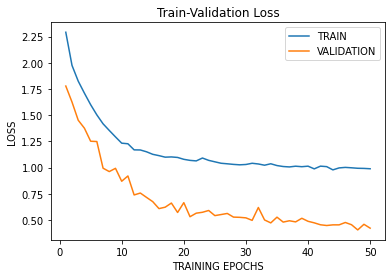

In [ ]:
# Plotting training/cross-validation losses over epochs
plt.title("Train-Validation Loss")
plt.plot(range(1, TRAINING_EPOCHS+1), loss_hist['train'], label='TRAIN')
plt.plot(range(1, TRAINING_EPOCHS+1), loss_hist['val'], label='VALIDATION')
plt.ylabel('LOSS')
plt.xlabel('TRAINING EPOCHS')
plt.legend()
plt.show()